In [2]:
# Data Preprocessing Template

using DataFrames
using CSV
using Random
using MLDataUtils
using GLM
using MLPreprocessing
using MLBase
using Colors

Random.seed!(0)

# Importing the dataset
df = CSV.File("Social_Network_Ads.csv") |> DataFrames.DataFrame!;

In [5]:
# Template parameters
extract_features = [ :Age, :EstimatedSalary ]
predictions_for  = :Purchased
categorical_f    = [ ]
split_size       = 1.0 - 0.25

# Encoding categorical data
if !isempty(categorical_f)
    categorical!(df, categorical_f);
end

X = Matrix(df[!, extract_features ]); # or df[!, 1:3] or : instead of ! for copy
y = df[!, predictions_for ];

# Splitting the dataset into the Training set and Test set
(X_train, y_train), (X_test, y_test) = splitobs(shuffleobs((X, y), obsdim = 1), at = split_size, obsdim = 1);

# Feature scaling
scaler  = fit(StandardScaler, X_train, obsdim = 1, operate_on = collect(1:size(X_train)[2]))
X_train = MLPreprocessing.transform(X_train, scaler);
X_test  = MLPreprocessing.transform(X_test, scaler);

# Creating rescaled DataFrames
df_train = DataFrame([ predictions_for => y_train, map(f -> f[2] => X_train[:, f[1]], enumerate(extract_features))... ]);
df_test  = DataFrame([ predictions_for => y_test, map(f -> f[2] => X_test[:, f[1]], enumerate(extract_features))... ]);

In [20]:
# Fitting kNN to The Training set
using NearestNeighbors
using StatsBase

classifier = KDTree(transpose(X_train), Euclidean())

KDTree{StaticArrays.SArray{Tuple{2},Float64,1,2},Euclidean,Float64}
  Number of points: 300
  Dimensions: 2
  Metric: Euclidean(0.0)
  Reordered: true

In [56]:
import StatsBase: predict

# Predicting the Test set results
function StatsBase.predict(classifier::C, df::D) where { C <: KDTree, D <: DataFrame }
    X = Matrix(df[!, extract_features ]);
    idxs, _ = knn(classifier, transpose(X), 5)
    return map(ids -> findmax(countmap(map(id -> y_train[id], ids)))[2], idxs);
end

y_pred = predict(classifier, df_test);

In [57]:
# Making the Confusion Matrix
cm = confusmat(2, map(y -> y + 1, y_test), map(y -> y + 1, y_pred))

2×2 Array{Int64,2}:
 59   4
  7  30

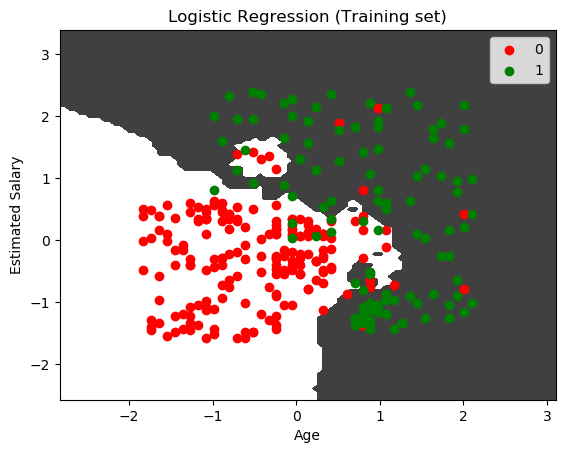

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


In [59]:
using PyPlot

X_set, y_set = X_train, y_train

resolution = 100

X1, X2 = range(minimum(X_set[:, 1]) - 1, maximum(X_set[:, 1]) + 1, length = resolution),
         range(minimum(X_set[:, 2]) - 1, maximum(X_set[:, 2]) + 1, length = resolution)

m   = [ (x1, x2) for x1 in X1 for x2 in X2 ]
c1  = map(t -> t[1], m)
c2  = map(t -> t[2], m)
dfp = DataFrame(extract_features[1] => c1, extract_features[2] => c2)
z   = reshape(predict(classifier, dfp), (resolution, resolution))

cmap1 = ColorMap([ colorant"red", colorant"green" ], 2)
cmap2 = ColorMap([ colorant"white", colorant"black" ], 2)

contourf(X1, X2, z, alpha = 0.75, levels = 1, cmap = cmap2)
xlim(minimum(X1), maximum(X1))
ylim(minimum(X2), maximum(X2))

for (i, j) in enumerate(unique(y_set))
    scatter(X_set[y_set .== j, 1], X_set[y_set .== j, 2], c = cmap1(i - 1), label = j)
end

title("Logistic Regression (Training set)")
xlabel("Age")
ylabel("Estimated Salary")
legend()
show()

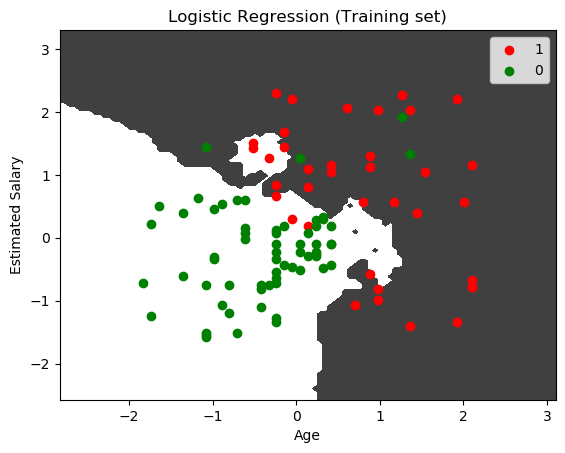

sys:1: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


In [60]:
X_set, y_set = X_test, y_test

resolution = 100

X1, X2 = range(minimum(X_set[:, 1]) - 1, maximum(X_set[:, 1]) + 1, length = resolution),
         range(minimum(X_set[:, 2]) - 1, maximum(X_set[:, 2]) + 1, length = resolution)

m   = [ (x1, x2) for x1 in X1 for x2 in X2 ]
c1  = map(t -> t[1], m)
c2  = map(t -> t[2], m)
dfp = DataFrame(extract_features[1] => c1, extract_features[2] => c2)
z   = reshape(predict(classifier, dfp), (resolution, resolution))

cmap1 = ColorMap([ colorant"red", colorant"green" ], 2)
cmap2 = ColorMap([ colorant"white", colorant"black" ], 2)

contourf(X1, X2, z, alpha = 0.75, levels = 1, cmap = cmap2)
xlim(minimum(X1), maximum(X1))
ylim(minimum(X2), maximum(X2))

for (i, j) in enumerate(unique(y_set))
    scatter(X_set[y_set .== j, 1], X_set[y_set .== j, 2], c = cmap1(i - 1), label = j)
end

title("Logistic Regression (Training set)")
xlabel("Age")
ylabel("Estimated Salary")
legend()
show()